In [1]:
%matplotlib inline
%load_ext autoreload
% autoreload 2

In [2]:
import numpy as np
import pandas  as pd
np.random.seed(151)

In [28]:
from chainer import Chain,Variable
import chainer.links as L
import chainer.functions as F
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater,Trainer
from chainer.training.extensions import PrintReport,LogReport,Evaluator
from sklearn.preprocessing import StandardScaler
from chainer.datasets import TupleDataset
from chainer.optimizers import Adam
from sklearn.metrics import classification_report

## データの読み込み

In [4]:
train = pd.read_csv("data/train.csv")
dev = pd.read_csv("data/dev.csv")
test = pd.read_csv("data/test.csv")

## データの確認

In [5]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.255258,-0.051533,-0.083768,-0.199902,0.394740,-0.374884,-0.225247,0.289441,-0.356663,-0.118184,...,-0.869127,0.014290,-0.338333,-0.996121,-0.666106,-0.760867,0.263355,0.021626,8,WALKING
1,0.275877,-0.019070,-0.134976,-0.996415,-0.974626,-0.962391,-0.996702,-0.973630,-0.958838,-0.942446,...,-0.916135,-0.013890,-0.218391,0.012162,0.490032,-0.803546,0.229476,0.053515,28,SITTING
2,0.275889,-0.019306,-0.109075,-0.995904,-0.986940,-0.984073,-0.996516,-0.986130,-0.984043,-0.940218,...,-0.823916,0.093677,-0.295563,0.383444,-0.851732,-0.737762,0.164248,0.193946,23,STANDING
3,0.244993,-0.016488,-0.104796,-0.284967,0.322228,-0.436234,-0.334029,0.226527,-0.429581,-0.130974,...,-0.672261,0.839361,0.376752,-0.107365,0.214366,-0.782859,0.244063,-0.018298,6,WALKING
4,0.285473,-0.024408,-0.086753,-0.978880,-0.866417,-0.910604,-0.984322,-0.882104,-0.912848,-0.903619,...,0.020834,-0.099957,-0.017790,-0.241290,0.819461,-0.643430,0.306376,0.150995,21,STANDING


## データの前処理

In [6]:
activity_type = train["Activity"].unique()
activity_to_id = dict(zip(activity_type,np.arange(activity_type.shape[0])))

In [7]:
# 入力データと正解データに分割
train_X = train.drop(["subject","Activity"],axis=1)
train_Y = train["Activity"].map(lambda x:activity_to_id[x])

dev_X = dev.drop(["subject","Activity"],axis=1)
dev_Y = dev["Activity"].map(lambda x:activity_to_id[x])

test_X = test.drop(["subject","Activity"],axis=1)
test_Y = test["Activity"].map(lambda x:activity_to_id[x])

In [10]:
scaler = StandardScaler()

In [11]:
# データの正規化
train_X_scale = scaler.fit_transform(train_X).astype(np.float32)
dev_X_scale = scaler.fit_transform(dev_X).astype(np.float32)
test_X_scale = scaler.fit_transform(test_X).astype(np.float32)

In [12]:
train_Y = train_Y.values.astype(np.int32)
dev_Y = dev_Y.values.astype(np.int32)
test_Y = test_Y.values.astype(np.int32)

## ミニバッチ用のデータを作成

In [16]:
train_dataset = TupleDataset(train_X_scale,train_Y)
dev_dataset = TupleDataset(dev_X_scale,dev_Y)
test_dataset = TupleDataset(test_X_scale,test_Y)

In [17]:
train_iterator = SerialIterator(train_dataset,batch_size = 100 , repeat = True)
dev_iterator = SerialIterator(dev_dataset,batch_size = 100,shuffle=False,repeat=False)
test_iterator = SerialIterator(test_dataset,batch_size = 100,shuffle=False,repeat=False)

## モデルの定義

In [23]:
class Model(Chain):
    def __init__(self):
        super(Model,self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(561,200)
            self.l2 = L.Linear(200,100)
            self.l3 = L.Linear(100,70)
            self.l4 = L.Linear(70,50)
            self.l5 = L.Linear(50,30)
            self.l6 = L.Linear(30,20)
            self.l7 = L.Linear(20,10)
            self.l8 = L.Linear(10,6)
    
    def __call__(self,x):
        h = F.relu(self.l1(x))
        h = F.dropout(h,ratio=0.3)
        h = F.relu(self.l2(h))
        h = F.dropout(h,ratio=0.3)
        h = F.relu(self.l3(h))
        h = F.dropout(h,ratio=0.3)
        h = F.relu(self.l4(h))
        h = F.dropout(h,ratio=0.3)
        h = F.relu(self.l5(h))
        h = F.dropout(h,ratio=0.3)
        h = F.relu(self.l6(h))
        h = F.dropout(h,ratio=0.3)
        h = F.relu(self.l7(h))
        h = F.dropout(h,ratio=0.3)
        return self.l8(h)

In [36]:
model = Model()
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(10000,'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(100,'iteration'))
trainer.extend(PrintReport(['iteration','main/loss','validation/main/loss','main/accuracy','validation/main/accuracy']))

logreport = LogReport(trigger=(100,'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
100         1.54684     1.07656               0.3055         0.498056                  
200         1.14238     0.638219              0.4772         0.679444                  
300         0.799881    0.414953              0.5959         0.744167                  
400         0.641916    0.356515              0.6776         0.804861                  
500         0.580426    0.399773              0.7288         0.816389                  
600         0.539652    0.309645              0.7521         0.839583                  
700         0.516066    0.306324              0.7587         0.822083                  
800         0.48975     0.32566               0.7673         0.814583                  
900         0.476982    0.283711              0.7713         0.813333                  
1000        0.44765     0.359841              0.7788         0.834861                  
1100        0.441721    0.270182  

9100        0.127704    0.0629028             0.9672         0.972778                  
9200        0.110342    0.0649937             0.9682         0.977778                  
9300        0.110132    0.064665              0.9714         0.977778                  
9400        0.110024    0.0612924             0.971          0.9825                    
9500        0.114369    0.0732355             0.9685         0.976528                  
9600        0.108609    0.0547242             0.9703         0.98375                   
9700        0.101277    0.0521758             0.9714         0.985                     
9800        0.106342    0.0534177             0.9715         0.98375                   
9900        0.184871    0.0582694             0.959          0.980278                  


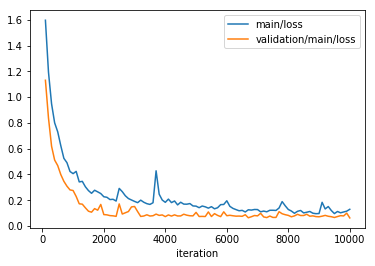

In [27]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"], index=log_df["iteration"]).plot()

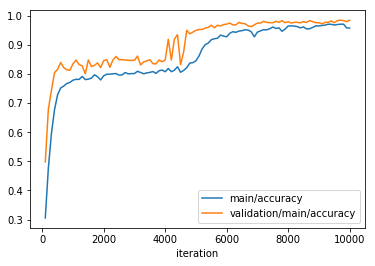

In [37]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/accuracy", "validation/main/accuracy"]].values, columns=["main/accuracy", "validation/main/accuracy"], index=log_df["iteration"]).plot()

## モデルへのテストデータの当てはめ

In [29]:
y = model(test_X_scale)

In [30]:
pred = np.argmax(y.data,axis=1)

## precision / recall / f1値の算出

In [31]:
print(classification_report(test_Y,pred))

             precision    recall  f1-score   support

          0       0.97      0.93      0.95       496
          1       0.86      0.93      0.89       491
          2       0.94      0.88      0.91       532
          3       0.93      0.95      0.94       471
          4       0.96      0.97      0.96       537
          5       0.92      0.91      0.91       420

avg / total       0.93      0.93      0.93      2947



In [32]:
pd.crosstab(test_Y,pred)

col_0,0,1,2,3,4,5
row_0,,,,,,
0,462,0,0,11,3,20
1,0,459,26,2,4,0
2,0,58,466,0,8,0
3,6,4,0,447,3,11
4,0,9,5,1,521,1
5,10,5,0,20,4,381


In [35]:
activity_to_id

{'LAYING': 4,
 'SITTING': 1,
 'STANDING': 2,
 'WALKING': 0,
 'WALKING_DOWNSTAIRS': 5,
 'WALKING_UPSTAIRS': 3}

- 2:STANDINGを1:SITTINGと誤って判断している場合が多い